In [ ]:
# Start by generating data with RedditAnalysis_comments_by_subreddit_by_year.py

In [1]:
import gzip
import json
from PIL import Image

In [2]:
# First assemble the list of _all_ unique subreddits.
subreddit_to_id = dict()
id_to_subreddit = list()
subreddit_id_to_post_count = list()

for year in range(2007, 2016):
    # Load data for the year:
    with gzip.open(f"reddit_comment_tally_{year}.json.gz", 'rt') as fin:
        data = json.load(fin)
    # Collect the unique subreddits.
    for user_name, post_counts in data.items():
        for subreddit_name, subreddit_posts in post_counts.items():
            if subreddit_name.lower() not in subreddit_to_id:
                subreddit_to_id[subreddit_name.lower()] = len(subreddit_to_id)
                id_to_subreddit.append(subreddit_name.lower())
                subreddit_id_to_post_count.append(0)
            subreddit_id_to_post_count[subreddit_to_id[subreddit_name.lower()]] += subreddit_posts


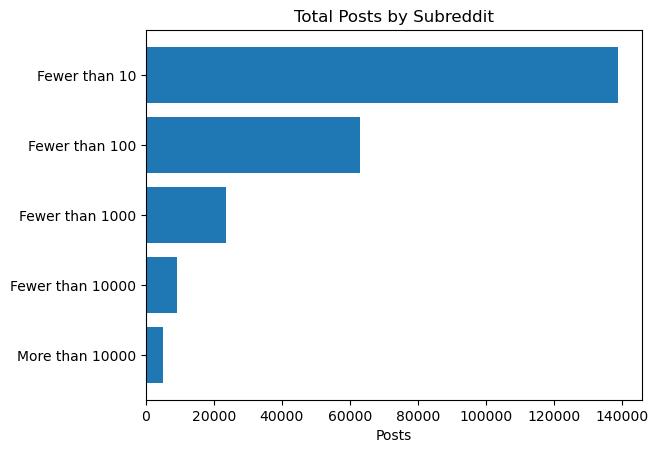

In [35]:
import math
import matplotlib.pyplot as plt
import numpy

plt.rcdefaults()
fig, ax = plt.subplots()

# Make histograms.
names =   ["Fewer than 10", "Fewer than 100", "Fewer than 1000", "Fewer than 10000", "More than 10000"]
buckets = [0,               0,                0,                 0,                   0               ]
for pc in subreddit_id_to_post_count:
    buckets[min(int(math.log(pc)/math.log(10)), 4)] += 1

y_pos = numpy.arange(len(names))
posts = numpy.asarray(buckets)
error = numpy.zeros(len(names))

ax.barh(y_pos, posts, xerr=error, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(names)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Posts')
ax.set_title('Total Posts by Subreddit')

plt.show()


In [37]:
# Filter the subreddits with fewerthan 1000 posts over ten years.
print(f"Before filtering: {len(subreddit_to_id)}")

subreddit_to_id_filtered = dict()
id_to_subreddit_filtered = list()

for sub_name, sub_id in subreddit_to_id.items():
    if subreddit_id_to_post_count[sub_id] > 1000:
        id_to_subreddit_filtered.append(len(subreddit_to_id_filtered))
        subreddit_to_id_filtered[sub_name] = len(subreddit_to_id_filtered)

subreddit_to_id = subreddit_to_id_filtered
id_to_subreddit = id_to_subreddit_filtered

print(f"After filtering: {len(subreddit_to_id)}")

Before filtering: 239772
After filtering: 14290


In [47]:
# If someone posts to both r/aww and r/catsstandingup, we consider these subreddits to be more likely to transition to each other.
# We take a user's posting habits, normalize them (so if they post to r/funny 900 times and r/gifs 100 times, we have a score of 0.9 for r/funny and 0.1 for r/gifs.)
# Then we accumulate on our gigantic matrix.
# Eventually we'll do the power series of the matrix.  We have the immediate effects of people posting in subreddits a and b, but what if we want to trace from a source like r/conservative to see how often posters from there move to other subs?
# Calculate first-order effects first.
import numpy

# TODO: We should do this by year when we have enough space for all matrices.
edge_weights_by_year = dict()
# transition_matrix.size*transition_matrix.itemsize = 74439339552
# I only have 64 gigs of ram, and 239772 rows * 239772 columns * 8 bytes = 459924895872 bytes.  459gigs.
# If we use edge_weights, a dict of dicts, we get a sparse matrix and deliberately fragmented memory.

for year in range(2007, 2016):
    print(f"Processing {year}...")
    
    # Load data for the year:
    print("Reading data...")
    with gzip.open(f"reddit_comment_tally_{year}.json.gz", 'rt') as fin:
        data = json.load(fin)

    # Memory map a file in temp:
    #print("Memory mapping matrix...")
    #edge_weights = numpy.memmap(f"C:\\temp\\{year}_memmap.npy", dtype='float32', mode='w+', shape=(len(id_to_subreddit),len(id_to_subreddit)))
    edge_weights = numpy.zeros((len(id_to_subreddit), len(id_to_subreddit)), dtype=numpy.float)
    
    # We will get a series of 'user vectors', which consist of the counts of the places where a user posts.
    # We want to estimate the 'probability' that a person transitions from one subreddit to another.
    # To do this, we COULD just add 1+log(posts) on the edge from subreddit[a]->[b] and let the log help us keep the numbers under control, but instead we normalize based on the number of posts so each row counts as one person.
    print("Procesing comments...")
    for user_name, post_counts in data.items():
        # Accumulate total posts so we can normalize.
        total_posts = 0
        for _, subreddit_posts in post_counts.items():
            total_posts += subreddit_posts
        if total_posts == 0:
            continue
            
        # Bump the number of times A and B are active together.
        for subreddit_name_a, subreddit_posts_a in post_counts.items():
            subreddit_id_a = subreddit_to_id.get(subreddit_name_a.lower())
            if subreddit_id_a is None:
                continue
            for subreddit_name_b, subreddit_posts_b in post_counts.items():
                subreddit_id_b = subreddit_to_id.get(subreddit_name_b.lower())
                if subreddit_id_b is None:
                    continue
                edge_weights[subreddit_id_a,subreddit_id_b] += float(subreddit_posts_a+subreddit_posts_b)/float(total_posts)
                # Considering NPMI here instead.
    edge_weights_by_year[year] = edge_weights
    
    print("Done!")

Processing 2007...
Reading data...
Procesing comments...
Done!
Processing 2008...
Reading data...
Procesing comments...
Done!
Processing 2009...
Reading data...
Procesing comments...
Done!
Processing 2010...
Reading data...
Procesing comments...
Done!
Processing 2011...
Reading data...
Procesing comments...
Done!
Processing 2012...
Reading data...
Procesing comments...
Done!
Processing 2013...
Reading data...
Procesing comments...
Done!
Processing 2014...
Reading data...
Procesing comments...
Done!
Processing 2015...
Reading data...
Procesing comments...
Done!


In [74]:
max_posts_by_year_by_row = numpy.zeros((2016-2007, edge_weights_by_year[2007].shape[0]), dtype=numpy.uint32)
for year in range(2007, 2016):
    max_posts_by_year_by_row[year-2007,:] = numpy.max(edge_weights_by_year[2007], axis=1)

In [69]:
from PIL import Image

In [ ]:
with gzip.open(f"edge_weights_all.json.gz", 'wt') as fout:
    json.dump({"id_to_name": id_to_subreddit, "weights": edge_weights}, fout)

In [66]:
edge_weights_by_year[2008][subreddit_to_id['aww'],subreddit_to_id['bayarea']]

0.00039127445307049144

In [70]:
with open("id_to_subreddit.json", 'wt') as fout:
    json.dump(id_to_subreddit, fout)
with open("subreddit_to_id.json", 'wt') as fout:
    json.dump(subreddit_to_id, fout)  # Redundant

In [73]:
for year, weights in edge_weights_by_year.items():
    #img = Image.fromarray(weights)
    numpy.save(f"weights_raw_{year}", weights)